In [1]:
import torch, os, math
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load_inline

In [2]:
from cuda_util import load_cuda

In [2]:
img = io.read_image('torch_cuda/rilak.jpg')
print(img.shape)

torch.Size([3, 600, 600])


In [3]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [4]:
img2 = tvf.resize(img, 150, antialias=True)
ch,h,w = img2.shape
ch,h,w,h*w

(3, 150, 150, 22500)

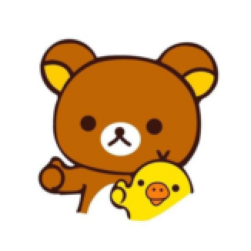

In [5]:
show_img(img2)

In [6]:
def rgb2grey_py(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    for i in range(n): 
        res[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]
    return res.view(h,w)

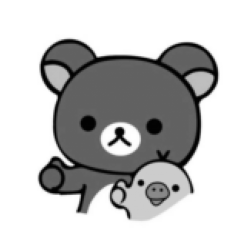

In [7]:
img_g = rgb2grey_py(img2)
show_img(img_g, cmap='gray')

In [8]:
def run_kernel(f, times, *args):
    for i in range(times): 
        f(i, *args)

In [9]:
def rgb2grey_k(i, x, out, n):
    out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]

In [10]:
def rgb2grey_pyk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    run_kernel(rgb2grey_k, h*w, x, res, n)
    return res.view(h,w)

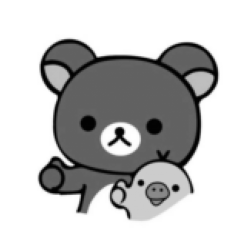

In [11]:
img_g = rgb2grey_pyk(img2)
show_img(img_g, cmap='gray')

In [12]:
def blk_kernel(f, blocks, threads, *args):
    for i in range(blocks):
        for j in range(threads): 
            f(i, j, threads, *args)


def rgb2grey_bk(blockidx, threadidx, blockdim, x, out, n):
    i = blockidx*blockdim + threadidx
    if i < n:
        out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n]     


def rgb2grey_pybk(x):
    c,h,w = x.shape
    n = h*w
    x = x.flatten()
    res = torch.empty(n, dtype=x.dtype, device=x.device)
    threads = 256
    blocks = int(math.ceil(h*w/threads))
    blk_kernel(rgb2grey_bk, blocks, threads, x, res, n)
    return res.view(h,w)

## Matrix Multiplication

In [55]:
cuda_src = open("matmul.cu").read()

In [15]:
cpp_src = "torch::Tensor torchMatmul(torch::Tensor a, torch::Tensor b);"

In [3]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [5]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [51]:
a = torch.randn(10, 30)
b = torch.randn(30, 5)

In [56]:
extension = load_cuda(cuda_src, cpp_src, funcs=["torchMatmul"])

/home/aki/workspace/learning/cuda/.venv/lib/python3.13/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [52]:
ac, bc = a.contiguous().cuda(), b.contiguous().cuda()

In [57]:
c = extension.torchMatmul(ac, bc)

In [58]:
torch.isclose(ac@bc, c)

tensor([[True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True],
        [True, True, True, True, True]], device='cuda:0')

In [33]:
ac@bc

tensor([[ -0.7966,  -3.9602,   4.2017,  -1.5886,   2.1908],
        [  4.4579,  -6.1993,   8.9966,   2.3652,  11.7463],
        [  1.2760,  -5.6961,  -1.9882,   2.4681,   2.1068],
        [  9.1638,  -4.8776,   7.3670, -10.3975,   4.5701],
        [  0.4671,   7.7471,  -3.1183,   6.7757, -10.4590],
        [-13.1127,  -0.2814,  -6.0010,  -5.5330,  -8.9905],
        [ -1.4710,  -2.9025,   6.3614,  -2.6347,  -4.4999],
        [  0.5610,  -3.7313,  -4.2857,  -7.7839,  -4.2926],
        [ -1.4614,   2.0539,  -2.6246,  -2.7162, -12.9611],
        [  9.1335,  -5.1033,  -4.9176,   2.9840,  11.5549]], device='cuda:0')

In [32]:
c

tensor([[-7.9655e-01, -3.9602e+00,  4.2017e+00, -1.5886e+00,  2.1908e+00],
        [ 0.0000e+00,  4.7684e-07,  4.7684e-07,  0.0000e+00,  1.1921e-07],
        [ 4.7684e-07,  4.7684e-07,  2.3842e-07,  4.7684e-07,  5.9605e-08],
        [ 2.8610e-06,  4.7684e-07,  9.5367e-07,  1.1921e-07,  2.3842e-07],
        [ 2.3842e-07,  1.9073e-06,  9.5367e-07,  9.5367e-07,  1.1921e-07],
        [ 4.7684e-07,  1.4305e-06,  0.0000e+00,  1.1921e-07,  2.3842e-07],
        [ 4.7684e-07,  3.5763e-07,  4.7684e-07,  9.5367e-07,  9.5367e-07],
        [ 9.5367e-07,  9.5367e-07,  0.0000e+00,  8.3447e-07,  4.7684e-07],
        [ 3.5763e-07,  1.1921e-06,  4.7684e-07,  0.0000e+00,  4.7684e-07],
        [ 0.0000e+00,  0.0000e+00,  2.3842e-07,  9.5367e-07,  4.7684e-07]],
       device='cuda:0')